In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import string

from urllib.request import urlopen
from bs4 import BeautifulSoup
import datetime
import random
import re

In [2]:
from google.colab import drive
drive.mount('/content/gDrive')

Drive already mounted at /content/gDrive; to attempt to forcibly remount, call drive.mount("/content/gDrive", force_remount=True).


In [3]:
# Extracting dylan lyrics from the web

with open('/content/gDrive/My Drive/dylan_metro.txt', 'w') as file:
    for i in range(1,12):
        page = urlopen('https://www.metrolyrics.com/bob-dylan-alpage-{}.html'.format(i))
        page_bs = BeautifulSoup(page, 'html.parser')
        for link in page_bs.find('div', {'class':'content'}).find_all('a', href=True):
            new_page = urlopen(link['href'])
            new_bs = BeautifulSoup(new_page, 'html.parser')
            data = new_bs.find_all('p', {'class':'verse'})
            file.write(str(data))
            file.write('\n')

In [3]:
data = open('/content/gDrive/My Drive/dylan_metro.txt').read()

In [29]:
data[:1000]

'well my nerves are exploding \nand my bodys tense \ni feel like the whole world \ngot me pinned up against the fence  ive been hit too hard \nive seen too much \nnothing can heal me now \nbut your touch  i just dont know what im gonna do \ni was alright til i fell in love with you  well my house is on fire \nburning to the sky \nwell i thought it would rain \nbut the clouds passed by  now i feel like im coming \nto the end of my way \nbut i know god is my shield \nand he wont lead me astray  still i dont know what im gonna do \ni was alright til i fell in love with you  boys in the street \nbeginning to play \ngirls like birds \nflying away  when im gone \nyou will remember my name \nim gonna win my way \nto wealth and fame  and i just dont know what im gonna do \ni was alright til i fell in love with you  well junk is piling up \ntaking up space \nmy eyes feel \nlike theyre falling off my face  sweat falling down \nim staring at the floor \nim thinking about that girl \nwho wont be b

In [5]:
# Data cleanup

def data_clean_round1(text):
    text = text.lower()                                                 # lower case text
    text = re.sub('<[^>]*>', ' ', text)                                    # remove all html tags
    #text = re.sub('\n', ' ', text)                                      # remove \n characters
    #text = re.sub('[]', ' ', text)                                     # remove square brackets
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)     # remove punctuations
    return text.strip()

In [6]:
data = data_clean_round1(data)

In [30]:
data[:1000]

'well my nerves are exploding \nand my bodys tense \ni feel like the whole world \ngot me pinned up against the fence  ive been hit too hard \nive seen too much \nnothing can heal me now \nbut your touch  i just dont know what im gonna do \ni was alright til i fell in love with you  well my house is on fire \nburning to the sky \nwell i thought it would rain \nbut the clouds passed by  now i feel like im coming \nto the end of my way \nbut i know god is my shield \nand he wont lead me astray  still i dont know what im gonna do \ni was alright til i fell in love with you  boys in the street \nbeginning to play \ngirls like birds \nflying away  when im gone \nyou will remember my name \nim gonna win my way \nto wealth and fame  and i just dont know what im gonna do \ni was alright til i fell in love with you  well junk is piling up \ntaking up space \nmy eyes feel \nlike theyre falling off my face  sweat falling down \nim staring at the floor \nim thinking about that girl \nwho wont be b

In [8]:
# another round of data cleaning

def data_clean_round2(text):
    text = re.sub('  ', ' ', text)
    text = re.sub('   ', ' ', text)
    return text

In [9]:
data = data_clean_round2(data)

In [31]:
data[:1000]

'well my nerves are exploding \nand my bodys tense \ni feel like the whole world \ngot me pinned up against the fence  ive been hit too hard \nive seen too much \nnothing can heal me now \nbut your touch  i just dont know what im gonna do \ni was alright til i fell in love with you  well my house is on fire \nburning to the sky \nwell i thought it would rain \nbut the clouds passed by  now i feel like im coming \nto the end of my way \nbut i know god is my shield \nand he wont lead me astray  still i dont know what im gonna do \ni was alright til i fell in love with you  boys in the street \nbeginning to play \ngirls like birds \nflying away  when im gone \nyou will remember my name \nim gonna win my way \nto wealth and fame  and i just dont know what im gonna do \ni was alright til i fell in love with you  well junk is piling up \ntaking up space \nmy eyes feel \nlike theyre falling off my face  sweat falling down \nim staring at the floor \nim thinking about that girl \nwho wont be b

In [32]:
# Tokenizing

corpus = data.split('\n')

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

total_words = len(tokenizer.word_index) + 1

print(total_words)
#print(tokenizer.word_index)

9339


In [12]:
# creating n_gram sequences
input_seq = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        ngram_seq = token_list[:i+1]
        input_seq.append(ngram_seq)
        
# pad sequences
max_seq_len = max([len(x) for x in input_seq])
input_seq = np.array(pad_sequences(input_seq, maxlen=max_seq_len, padding='pre'))

# create predictors and labels
xs, labels = input_seq[:,:-1], input_seq[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [14]:
# check word index with test lyric
print(tokenizer.word_index['oh'])
print(tokenizer.word_index['my'])
print(tokenizer.word_index['name'])
print(tokenizer.word_index['it'])
print(tokenizer.word_index['aint'])
print(tokenizer.word_index['nothin'])

64
9
244
13
63
309


In [15]:
# Modelling

model = Sequential([Embedding(total_words, 64, input_length=max_seq_len-1),
                   Bidirectional(LSTM(100, return_sequences=True)),
                   Dropout(0.2),
                   Bidirectional(LSTM(80)),
                   Dense(total_words/2, activation='relu'),
                   Dense(total_words, activation='softmax')
                   ])

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

model.summary()  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 59, 64)            597696    
_________________________________________________________________
bidirectional (Bidirectional (None, 59, 200)           132000    
_________________________________________________________________
dropout (Dropout)            (None, 59, 200)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 160)               179840    
_________________________________________________________________
dense (Dense)                (None, 4669)              751709    
_________________________________________________________________
dense_1 (Dense)              (None, 9339)              43613130  
Total params: 45,274,375
Trainable params: 45,274,375
Non-trainable params: 0
____________________________________________

In [16]:
cp_path = '/content/gDrive/My Drive/dylan_weights.pt'

cp = tf.keras.callbacks.ModelCheckpoint(cp_path, 
                                        save_weights_only=True,
                                        period=5,
                                        verbose=1)

In [17]:
model.load_weights(cp_path)

history = model.fit(xs, labels, epochs=20, verbose=1, callbacks=[cp])

Epoch 1/20
4556/4556 [==============================] - 117s 26ms/step - loss: 0.7497 - accuracy: 0.8002
Epoch 2/20
4556/4556 [==============================] - 117s 26ms/step - loss: 0.7496 - accuracy: 0.8000
Epoch 3/20
4556/4556 [==============================] - 115s 25ms/step - loss: 0.7489 - accuracy: 0.8002
Epoch 4/20
4556/4556 [==============================] - 114s 25ms/step - loss: 0.7451 - accuracy: 0.8019
Epoch 5/20
4554/4556 [============================>.] - ETA: 0s - loss: 0.7457 - accuracy: 0.8016
Epoch 00005: saving model to /content/gDrive/My Drive/dylan_weights.pt
4556/4556 [==============================] - 117s 26ms/step - loss: 0.7457 - accuracy: 0.8016
Epoch 6/20
4556/4556 [==============================] - 115s 25ms/step - loss: 0.7443 - accuracy: 0.8015
Epoch 7/20
4556/4556 [==============================] - 115s 25ms/step - loss: 0.7456 - accuracy: 0.8015
Epoch 8/20
4556/4556 [==============================] - 114s 25ms/step - loss: 0.7402 - accuracy: 0.8023
Ep

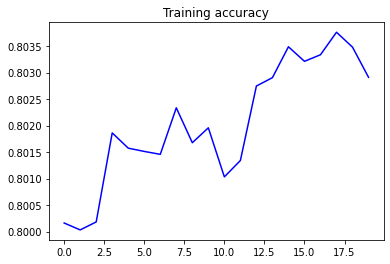

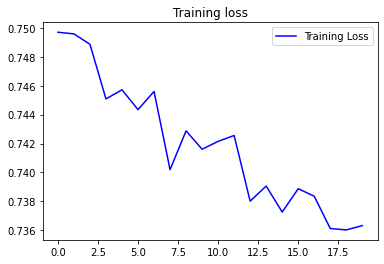

In [18]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [26]:
seed_text = "the world"
next_words = 60
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

the world has gone black before my eyes well the world of research has gone berserk is the brass new dreams are a country still in gold theres a house in a cadillac room he was up on a golden road of life i need a shot of love i need a shot of love dont make you leave faint up the


In [27]:
seed_text = "i was born"
next_words = 20
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

i was born to be a fiddler in an oldtime stringband on the road well its faretheewell my dear i will love you
